<a href="https://colab.research.google.com/github/LorenzoMauri/Advanced-Machine-Learning/blob/main/ASSIGNMENT1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Assignment 1**

## Import libraries 



In [5]:
!pip install geopandas

In [6]:
import os 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas
from time import sleep
import math
import statistics 
import numpy
import shapely
import geopy.distance
from shapely.geometry import Point,Polygon
from tensorflow import keras
import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from keras import backend as K


## Import data from Google Drive


In [7]:
os.chdir('/content/drive/My Drive/Advanced Machine Learning /assignment1/data')
x_train=pd.read_csv('X_train.csv').iloc[:, 1:]
y_train=pd.read_csv('y_train.csv').iloc[:, 1:]
x_test=pd.read_csv('X_test.csv').iloc[:, 1:]

training_set = x_train.copy()
test_set = x_test.copy()

df_complessivo = x_train.copy() 
df_complessivo['y'] = y_train
df_complessivo.head() 



,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Private_room,Entire_home/apt,y
0,40.71239,-73.95271,4,2,0.19,1,0,1,0,65
1,40696.00000,-73.91303,4,17,0.66,2,307,1,0,57
2,40.62707,-74.02817,3,1,0.04,1,87,0,0,225
3,40.77910,-73.98565,1,4,0.08,1,0,0,1,175
4,40.75777,-73.93509,1,0,0.00,1,358,1,0,125


## Exploratory analysis

In [8]:
print(training_set.shape)
training_set.head()

(33884, 9)


,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Private_room,Entire_home/apt
0,40.71239,-73.95271,4,2,0.19,1,0,1,0
1,40696.00000,-73.91303,4,17,0.66,2,307,1,0
2,40.62707,-74.02817,3,1,0.04,1,87,0,0
3,40.77910,-73.98565,1,4,0.08,1,0,0,1
4,40.75777,-73.93509,1,0,0.00,1,358,1,0


In [9]:
print(test_set.shape)
test_set.head()

(3765, 9)


,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Private_room,Entire_home/apt
0,40.68579,-73.97455,2,4,0.17,1,0,0,1
1,40.67085,-73.92316,1,9,0.61,1,0,1,0
2,40.68817,-73.91523,2,31,1.35,5,0,1,0
3,40.67201,-73.86944,3,0,0.00,2,363,1,0
4,40.68696,-73.92905,1,7,0.19,1,0,1,0


In [10]:
print(test_set.shape)
test_set.head()

(3765, 9)


,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Private_room,Entire_home/apt
0,40.68579,-73.97455,2,4,0.17,1,0,0,1
1,40.67085,-73.92316,1,9,0.61,1,0,1,0
2,40.68817,-73.91523,2,31,1.35,5,0,1,0
3,40.67201,-73.86944,3,0,0.00,2,363,1,0
4,40.68696,-73.92905,1,7,0.19,1,0,1,0


* checking columns types 

In [11]:
training_set.dtypes

latitude                          float64
longitude                         float64
minimum_nights                      int64
number_of_reviews                   int64
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
Private_room                        int64
Entire_home/apt                     int64
dtype: object

In [12]:
test_set.dtypes

latitude                          float64
longitude                         float64
minimum_nights                      int64
number_of_reviews                   int64
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
Private_room                        int64
Entire_home/apt                     int64
dtype: object

* checking missing values 

In [13]:
training_set.isnull().sum()

latitude                          0
longitude                         0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
Private_room                      0
Entire_home/apt                   0
dtype: int64

In [14]:
test_set.isnull().sum()

latitude                          0
longitude                         0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
Private_room                      0
Entire_home/apt                   0
dtype: int64

In [15]:
training_set.describe()

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Private_room,Entire_home/apt
count,33884.000000,33884.000000,33884.000000,33884.000000,33884.000000,33884.000000,33884.000000,33884.000000,33884.000000
mean,393.742123,-767.324528,7.109904,23.391778,1.095455,7.101080,112.995839,0.456085,0.520127
std,3773.366411,7123.758128,20.234836,44.608022,1.610452,32.746915,131.641035,0.498075,0.499602
min,40.499790,-74142.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,40.690427,-73.983503,1.000000,1.000000,0.040000,1.000000,0.000000,0.000000,0.000000
50%,40.723645,-73.956025,3.000000,5.000000,0.370000,1.000000,45.000000,0.000000,1.000000
75%,40.763910,-73.937005,5.000000,24.000000,1.590000,2.000000,227.000000,1.000000,1.000000
max,40894.000000,-73.712990,1000.000000,629.000000,58.500000,327.000000,365.000000,1.000000,1.000000


In [16]:
test_set.describe()

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Private_room,Entire_home/apt
count,3765.000000,3765.000000,3765.000000,3765.000000,3765.000000,3765.000000,3765.000000,3765.000000,3765.000000
mean,397.429772,-623.385344,7.717663,22.546348,1.073421,8.124568,115.432669,0.451262,0.526959
std,3793.819578,6348.269973,31.688428,42.644924,1.553516,37.043267,132.790393,0.497685,0.499339
min,40.507080,-74124.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,40.689430,-73.984260,1.000000,1.000000,0.040000,1.000000,0.000000,0.000000,0.000000
50%,40.723370,-73.956270,2.000000,5.000000,0.380000,1.000000,51.000000,0.000000,1.000000
75%,40.763420,-73.935150,5.000000,24.000000,1.550000,2.000000,231.000000,1.000000,1.000000
max,40833.000000,-73.724350,1250.000000,447.000000,20.940000,327.000000,365.000000,1.000000,1.000000


In [17]:
print(test_set[['latitude','longitude']].min())
training_set[['latitude','longitude']].min()

latitude        40.50708
longitude   -74124.00000
dtype: float64


latitude        40.49979
longitude   -74142.00000
dtype: float64

In [18]:
print(test_set[['latitude','longitude']].max())
training_set[['latitude','longitude']].max()

latitude     40833.00000
longitude      -73.72435
dtype: float64


latitude     40894.00000
longitude      -73.71299
dtype: float64

* anomaly detection 

Dalle descrittive fornite da pandas notiamo subito alcune criticità:

> `latitudine` e `longitudine` :
>>le coordinate che identificano New York City sono (40.730610,-73.935242) pertanto le coordinate delle altre abitazioni non potranno discostarsi molto da quei valori. Osserviamo che il valore massimo per la è `latitudine` 40894.0 mentre il valore minimo per la `longitudine` è -74142.0 . 
**Soluzione proposta** : una più accurata analisi ci fa notare che il separatore virgola è erroneamente spostato di 3 cifre : basterà quindi dividere tutti i valori errati per 1000.

> `price` : 
>> alcune abitazioni hanno prezzo nullo. **Soluzione proposta** : In questo caso non ha senso mantenere l'osservazione nel dataframe, perciò decidiamo di rimuoverla.



In [19]:
def unbias(row):
  if abs(row) > 1000 :
    return row/1000.0
  else : return row

df_complessivo['latitude']=df_complessivo['latitude'].apply(unbias)
df_complessivo['longitude']=df_complessivo['longitude'].apply(unbias)

df_complessivo.head()


,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Private_room,Entire_home/apt,y
0,40.71239,-73.95271,4,2,0.19,1,0,1,0,65
1,40.69600,-73.91303,4,17,0.66,2,307,1,0,57
2,40.62707,-74.02817,3,1,0.04,1,87,0,0,225
3,40.77910,-73.98565,1,4,0.08,1,0,0,1,175
4,40.75777,-73.93509,1,0,0.00,1,358,1,0,125


In [ ]:
coordinates_complessivo = [Point(xy) for xy in zip(df_complessivo.longitude,df_complessivo.latitude)]
df_complessivo=geopandas.GeoDataFrame(df_complessivo, geometry=coordinates_complessivo,crs={'init':'epsg:4326'})
df_complessivo.head()

In [37]:
boroughs = geopandas.read_file(geopandas.datasets.get_path("nybb"))

pandas.core.series.Series

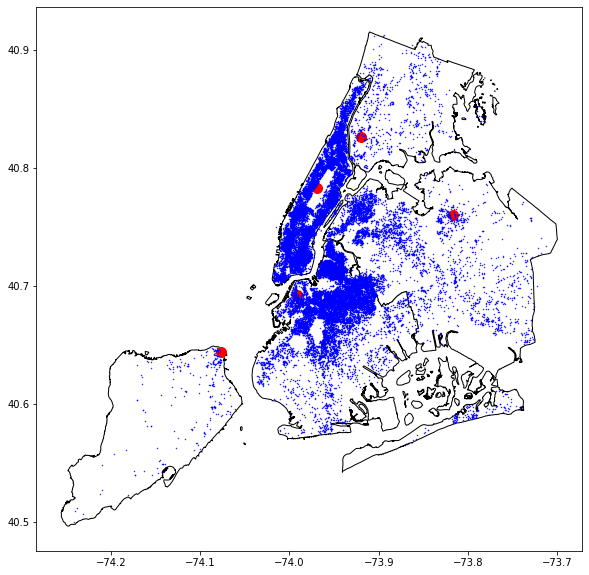

In [54]:
fig, ax = plt.subplots(figsize = (10,10))
boroughs_locations = geopandas.tools.geocode(boroughs.BoroName.to_list())
boroughs.to_crs("EPSG:4326").plot(ax=ax, color="white", edgecolor="black")
boroughs_locations.plot(ax=ax, color="red",markersize = 100)
df_complessivo['geometry'].plot(ax=ax, color="blue",markersize = 0.2)


* Nota

> Osserviamo graficamente che la maggior parte delle abitazioni sono a Manhattan e Brooklyn 


* Svolgimento 

> Per associare un punto al proprio distretto possiamo calcolare le distanze tra il punto e i 5 distretti e considerare il distretto con distanza più piccola. 

In [55]:
df_complessivo['(lat,lon)']=df_complessivo[['latitude','longitude']].apply(lambda x: tuple(x), axis=1)


In [ ]:
def extract_coords(row):
  return (tuple((row.y,row.x)))
 
boroughs_locations['(lat,lon)']= boroughs_locations['geometry'].apply(extract_coords)

In [57]:
def distance(row):
  districts = {'staten island':0,'queens':1, 'brooklyn': 2, 'manhattan':3, 'bronx': 4} 
  min_dist = 10000000 
  min_district=''
  for district in districts:
    dist = geopy.distance.geodesic(row,boroughs_locations['(lat,lon)'].iloc[districts[district]]).kilometers
    if dist <= min_dist : 
      min_dist = dist
      min_district = districts[district]
  return min_district

df_complessivo['district']= df_complessivo['(lat,lon)'].apply(distance)



> Troviamo confermata la numerosità delle abitazioni distribuite nei quartieri di New York con quanto osservato graficamente.


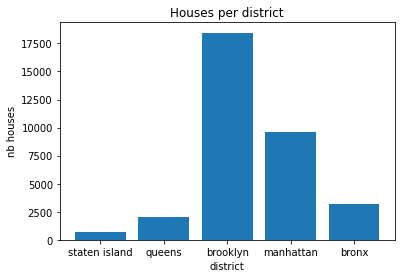

In [59]:
plt.bar(['staten island','queens', 'brooklyn', 'manhattan', 'bronx'],list(df_complessivo.groupby('district').size()))
plt.xlabel('district')
plt.ylabel('nb houses')
plt.title('Houses per district')
plt.show()

In [60]:
df_complessivo2 = df_complessivo[['district', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'Private_room', 'Entire_home/apt', 'y']]
df_complessivo2 = df_complessivo2[df_complessivo2['y']!=0]

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df_complessivo2.iloc[:,:-1], df_complessivo2.iloc[:,-1], test_size=0.20, random_state=42)

In [61]:
x_train.head()

,district,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Private_room,Entire_home/apt
22394,0,30,25,0.36,2,188,0,1
27282,1,4,44,2.33,2,39,0,1
20717,2,1,3,0.16,1,4,1,0
7338,3,3,42,0.99,1,3,1,0
5028,2,2,0,0.00,1,5,0,1


## Building deep learning algorithm

In [206]:
df_to_split=
epochs=30
batch=64
lr=0.001
u1=20
u2=10
alpha_leakyrelu = 0.6
train=True
x_train, x_test, y_train, y_test = train_test_split(df_to_split.iloc[:,:-1], df_to_split.iloc[:,-1], test_size=0.20, random_state=42)
model = Sequential()
weights_initialization_1 = keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None)
bias_initialization_1 = keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None)
weights_initialization_2 = keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None)
bias_initialization_2 = keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None)
f=keras.layers.LeakyReLU(alpha=alpha_leakyrelu)
model.add(Dense(units = u1 , input_dim=8,activation='relu',kernel_initializer = weights_initialization,bias_initializer=bias_initialization_1))
model.add(Dense(units = u2 ,activation=f,kernel_initializer = weights_initialization_2,bias_initializer=bias_initialization_2))
model.add(Dense(units = 1,activation = f))
opt= keras.optimizers.Adam(learning_rate=lr)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=[keras.metrics.RootMeanSquaredError()])
model.fit(x_train, y_train, epochs=epochs,validation_data=(x_test,y_test),batch_size = batch )

In [168]:
fig = plt.plot(figsize=(5,5))
plt.title('Training and Test Plot')
plt.plot(modello.history['root_mean_squared_error'],label='training')
plt.plot(modello.history['val_root_mean_squared_error'],label='test')
plt.legend()
plt.show()

In [186]:
a = model.predict(x_test)
predicted = pd.DataFrame(a)
actual = pd.DataFrame(y_test)
test = pd.DataFrame({'actual':y_test.to_list(),'predicted':predicted[0].to_list()})
test


In [77]:
predicted = pd.DataFrame(a)
actual = pd.DataFrame(y_test)
test = pd.DataFrame({'actual':y_test.to_list(),'predicted':predicted[0].to_list()})
test

,actual,predicted
0,163,168.632751
1,175,231.432800
2,200,169.601166
3,65,94.393730
4,81,111.994987
...,...,...
6771,277,176.929932
6772,67,88.870689
6773,45,92.548752
6774,40,104.635620


In [78]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 20)                180       
_________________________________________________________________
dense_11 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 11        
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#districts = pd.DataFrame({'district':['staten island','queens', 'brooklyn','manhattan', 'bronx'],'code':[0,1,2,3,4]})
#districts 
#new = pd.merge(training_set,districts,how='left',left_on='district',right_on = 'code')
#plt.figure(figsize=(10,6))
#sns.scatterplot(new.longitude,airbnb.latitude,hue=airbnb.neighbourhood_group)
#plt.ioff()

In [ ]:
#fig, ax = plt.subplots(figsize=(7,7))  
#sns.heatmap(round(training_set_2.corr(),3),annot=True, cmap="YlGnBu",ax=ax)

## Dataframe standardizzato
Standardizzo sia il `training set` che il `test set`

Dato gli attributi $(X,Y)$ e le osservazioni $(x,y)$ segue che :
\
\
$$
x_{standard} = \frac{x-\mu_X}{\sigma_X} 
$$
\
\
$$
y_{standard} = \frac{y-\mu_Y}{\sigma_Y} 
$$

Successivamente dal `test set` ottengo la previsione $\hat{y}$ che dovrà essere opportunemente trasformata 
\
\
$$
\hat{y} = \sigma_Y \ \hat{y}_{standard} + \mu_Y
$$

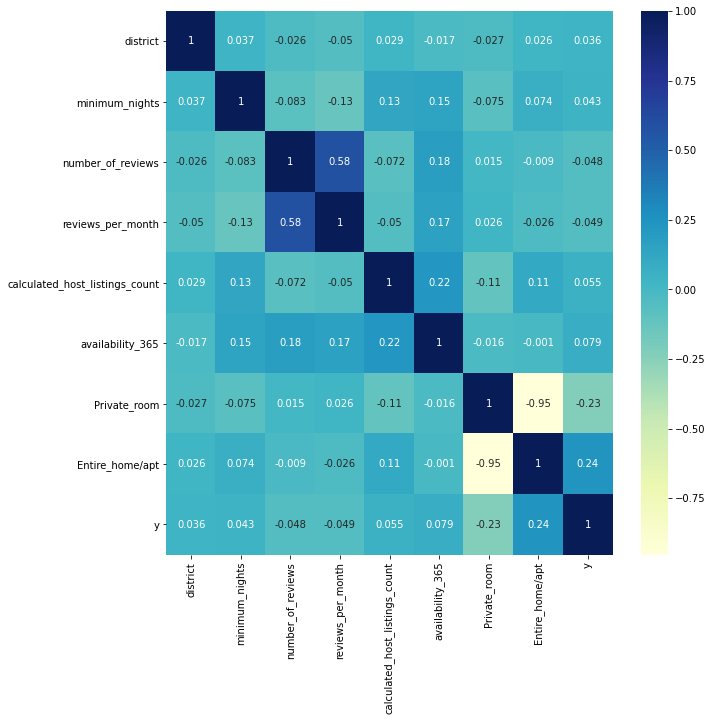

In [625]:
#fig, ax = plt.subplots(figsize=(10,10))  
#sns.heatmap(round(df_complessivo2.corr(),3),annot=True, cmap="YlGnBu",ax=ax)

In [228]:
def standardizzazione(x):
  diffmu =  x-numpy.mean(x)
  sd = math.sqrt(numpy.var(x))
  return diffmu/sd

df_complessivo_standard = df_complessivo2.apply(standardizzazione,axis=0)


In [643]:
df_complessivo2.columns

Index(['district', 'minimum_nights', 'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365', 'Private_room',
       'Entire_home/apt', 'y'],
      dtype='object')

In [ ]:
df_complessivo_standard[['minimum_nights', 'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365', 'Private_room',
       'Entire_home/apt', 'y']])

In [1267]:
def decay(init_lr,decay_rate,epoch):
  return init_lr / (1+decay_rate*epoch)
n=50
init_lr =.3
decay_rate = .015
l=[(round(decay(init_lr,decay_rate,i),4))for i in range(0,n+1)]
e =[i for i in range(0,n+1)]
pd.DataFrame({'learning_rate':l})

,learning_rate
0,0.3000
1,0.2956
2,0.2913
3,0.2871
4,0.2830
5,0.2791
6,0.2752
7,0.2715
8,0.2679
9,0.2643


In [1279]:
df_to_split=df_complessivo_standard
x_train, x_test, y_train, y_test = train_test_split(df_to_split.iloc[:,:-1], df_to_split.iloc[:,-1], test_size=0.05,random_state = 27102020)

epochs=50
batch=30
init_lr=.3
decay_rate = .015
leakyRELU = keras.layers.LeakyReLU(alpha=0.01)
leakyRELU_out = keras.layers.LeakyReLU(alpha=0.01)
upper = 0.5
lower = -0.5
model = Sequential()
bias_initialization_1 = 'zero'#keras.initializers.RandomUniform(minval=-1, maxval=1, seed=None)
bias_initialization_2 =  'zero'#keras.initializers.RandomUniform(minval=-1, maxval=1, seed=None)


model.add(Dense(units = 8 , 
                input_dim=8,
                activation= leakyRELU,
                kernel_initializer = keras.initializers.RandomUniform(minval=lower, maxval=upper, seed=None),
                bias_initializer=keras.initializers.RandomUniform(minval=lower, maxval=upper, seed=None)))

model.add(Dense(units = 128,
                activation=leakyRELU,
                kernel_initializer =  keras.initializers.RandomUniform(minval=lower, maxval=upper, seed=None),
                bias_initializer=keras.initializers.RandomUniform(minval=lower, maxval=upper, seed=None)))

model.add(Dense(units = 64,
                activation=leakyRELU,
                kernel_initializer =  keras.initializers.RandomUniform(minval=lower, maxval=upper, seed=None),
                bias_initializer=keras.initializers.RandomUniform(minval=lower, maxval=upper, seed=None)))

model.add(Dense(units = 1,
                activation=leakyRELU_out ))



opt = keras.optimizers.SGD(learning_rate=init_lr,decay=decay_rate,momentum=0.02,nesterov=True)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=[keras.metrics.RootMeanSquaredError()])
modello = model.fit(x_train, y_train, epochs=epochs,validation_data=(x_test,y_test),batch_size = batch )

Epoch 1/50
1073/1073 [==============================] - 1s 1ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 2/50
1073/1073 [==============================] - 1s 1ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 3/50
1073/1073 [==============================] - 1s 1ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 4/50
1073/1073 [==============================] - 1s 1ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 5/50
1073/1073 [==============================] - 1s 1ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 6/50
1041/1073 [============================>.] - ETA: 0s - loss: nan - root_mean_squared_error: nan

KeyboardInterrupt: ignored

In [1202]:
df_complessivo2.head()

,district,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Private_room,Entire_home/apt,y
0,2,4,2,0.19,1,0,1,0,65
1,2,4,17,0.66,2,307,1,0,57
2,0,3,1,0.04,1,87,0,0,225
3,3,1,4,0.08,1,0,0,1,175
4,3,1,0,0.00,1,358,1,0,125


In [1191]:
df_complessivo_standard.head()

,district,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Private_room,Entire_home/apt,y
0,-0.456212,-0.153653,-0.479503,-0.562213,-0.186312,-0.858294,1.092072,-1.041232,-0.355823
1,-0.456212,-0.153653,-0.143243,-0.270353,-0.155778,1.473741,1.092072,-1.041232,-0.387936
2,-2.921263,-0.203070,-0.501921,-0.655359,-0.186312,-0.197424,-0.915690,-1.041232,0.286445
3,0.776314,-0.301904,-0.434669,-0.630520,-0.186312,-0.858294,-0.915690,0.960401,0.085736
4,0.776314,-0.301904,-0.524338,-0.680198,-0.186312,1.861148,1.092072,-1.041232,-0.114973


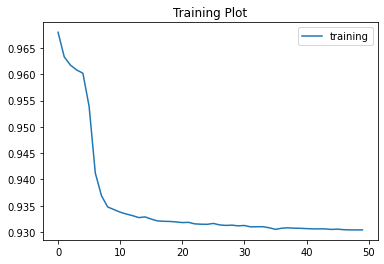

0.9304078817367554


In [1269]:
fig = plt.plot(figsize=(5,5))
plt.title('Training Plot')
plt.plot(modello.history['root_mean_squared_error'],label='training')
#plt.plot(modello.history['val_root_mean_squared_error'],label='test')
plt.legend()
plt.show()
print(modello.history['root_mean_squared_error'][-1])

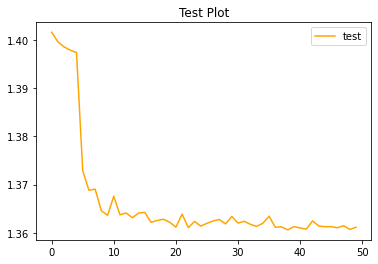

1.3611809015274048


In [1270]:
fig = plt.plot(figsize=(5,5))
plt.title('Test Plot')
#plt.plot(modello.history['root_mean_squared_error'],label='training')
plt.plot(modello.history['val_root_mean_squared_error'],label='test',color='orange')
plt.legend()
plt.show()
print(modello.history['val_root_mean_squared_error'][-1])

In [1271]:
a = model.predict(x_test)
a=[i[0] for i in a.tolist()]
mediaY= numpy.mean(df_complessivo2.y)
stdY = numpy.std(df_complessivo2.y)
predicted_scaled = pd.DataFrame(a)
actual = pd.DataFrame(y_test)
test = pd.DataFrame({'actual_scaled':y_test.to_list(),'predicted_scaled':a})
test['predicted']=test['predicted_scaled'].apply(lambda x : (x*stdY)+mediaY)
test['actual']=test['actual_scaled'].apply(lambda x : (x*stdY)+mediaY)
test['error']=abs(test.predicted-test.actual)
print(test.error.mean())
test

85.81156977642772


,actual_scaled,predicted_scaled,predicted,actual,error
0,1.386328,-0.222052,98.324765,499.0,400.675235
1,-0.315681,0.220288,208.519231,75.0,133.519231
2,-0.311667,-0.408443,51.891447,76.0,24.108553
3,0.145949,0.530407,285.775130,190.0,95.775130
4,-0.135043,0.135409,187.374271,120.0,67.374271
...,...,...,...,...,...
1689,-0.315681,-0.048493,141.561296,75.0,66.561296
1690,0.459054,0.505471,279.563182,268.0,11.563182
1691,1.390343,0.851822,365.845201,500.0,134.154799
1692,0.166020,0.289152,225.674439,195.0,30.674439


In [1272]:
test.iloc[320:340]

,actual_scaled,predicted_scaled,predicted,actual,error
320,-0.315681,-0.284189,82.845208,75.0,7.845208
321,1.189634,-0.022615,148.007904,450.0,301.992096
322,-0.094902,-0.238986,94.106230,130.0,35.893770
323,-0.395965,-0.239905,93.877073,55.0,38.877073
324,-0.456177,-0.269266,86.562779,40.0,46.562779
325,0.944769,-0.009094,151.376087,389.0,237.623913
326,-0.355823,-0.299699,78.981542,65.0,13.981542
327,-0.420050,-0.276803,84.685337,49.0,35.685337
328,-0.219341,-0.248084,91.839752,99.0,7.160248
329,-0.235398,0.491533,276.091072,95.0,181.091072


In [ ]:
model.weights()

In [950]:
model.summary()

Model: "sequential_223"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_699 (Dense)            (None, 8)                 72        
_________________________________________________________________
dense_700 (Dense)            (None, 64)                576       
_________________________________________________________________
dense_701 (Dense)            (None, 1)                 65        
Total params: 713
Trainable params: 713
Non-trainable params: 0
_________________________________________________________________
